# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 21
### <center> Yoshihiro Shirai

# Generative Adversarial Networks

## 1 Introduction to GANs

- Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow in 2014. It is a generative model, GANs are designed to generate new data samples that resemble a given dataset, such as images, time series, or text. The only other generative model we have seen so far is the Naive Bayes classifier. 

- A GAN consists of two neural network:
    - Generator, which tries to create fake data that looks as realistic as possible;
    - Discriminator, which tries to distinguish between real data (from the training set) and fake data (produced by the generator).

- At each step during training:
    - The generator improves its ability to produce realistic data to fool the discriminator.
    - The discriminator improves its ability to tell real from fake.

- This adversarial process continues until the generator produces data that the discriminator cannot reliably distinguish from real data.

- GANs have become a powerful tool for generative modeling in many fields, including finance, art, and science. It is particularly suitable as a numerical technic for the spectral synthesis problem in Harmonic analysis, i.e. the problem of modifying the decomposition in the trigonometric basis of $L^2$ (or any other basis of any other suitable Banach space) of a signal to generate new ones. The types of signals synthesized may be images, sounds, videos and, of course, time series.



## 2. Training GANs

A Generative Adversarial Network (GAN) consists of two neural networks, a generator $G$ and a discriminator $D$, that are trained simultaneously through adversarial processes.

1. Generator $( G )$
- The generator takes as input a random noise vector $z$ sampled from a prior distribution $p_z(z)$ (often a standard normal distribution).
- It outputs a synthetic data sample $G(z)$ intended to resemble real data.

2. Discriminator $( D )$
- The discriminator receives as input either a real data sample $x \sim \mathbb{P}$ and a fake sample $G(z)$, where $z\sim\mathbb{Q}$.
- Note that $z$ may be a vector of any length $f$, where $f$ is called the receptive field
- It outputs a probability $D(x) \in [0, 1]$ representing the likelihood that $x$ is real.

3. Objective Function
- The GAN training objective is a minimax game between $( G )$ and $( D )$:
$$
\min_G \max_D V(D, G) = \mathbb{E}^{\mathbb{P}} [\log D(x)] + \mathbb{E}^{\mathbb{Q}} [\log(1 - D(G(z)))]
$$
- The higher the value of $V$, the higher the ability of the discrimator, on average, to correctly distinguish between real and fake data
- The lower the value, the higher the ability of the generator, on average, to fool the discriminator

4. Algorithm (Pseudocode)
For each training iteration:
- Sample a minibatch of real data ${x^{(1)}, ..., x^{(m)}}$ from $\mathbb{P}$.
Sample a minibatch of noise ${z^{(1)}, ..., z^{(m)}}$ from $\mathbb{Q}$.
Update the discriminator by stochastic gradient ascent: 
$$
\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]
$$
- Sample another minibatch of noise ${z^{(1)}, ..., z^{(m)}}$.
- Update the generator by descending its stochastic gradient: 
$$
[ \nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \log(1 - D(G(z^{(i)}))) ]
$$
or (non-saturating loss): 
$$
[ \nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m -\log D(G(z^{(i)})) ]
$$

5. Summary
- The generator and discriminator are trained in turns.
- The generator learns to produce data that is indistinguishable from real data.
- The discriminator learns to distinguish real from fake data.
- Training continues until the discriminator cannot reliably tell real from fake (i.e., $D(x) \approx 0.5$ for all $x$).

6. References:
Goodfellow, I. et al. (2014). Generative Adversarial Nets ([Arxiv](https://arxiv.org/abs/1412.6515))

## 3. QuantGAN, TAGAN and SAGAN

- The general GAN framework works well for non sequential data, such as image generation

- In finance, of course, one is mainly interested at synthesizing time series 

- Training in this case can be achieved using the time series generative adversarial network (TGAN, [Yoon et al, 2019](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf)) model

- Here the following model is considered:
    - $\mathbb{P}$ is a uniform distribution over the window data of length $\ell$,so that each sample $x^{(i)}$ of the minibatch is a vector $x_{i:i+\ell-1}$
    - Similarly, each $z^{(i)}$ is now a vector of length $\ell+f$
    - The first $\ell$ elements of $z^{(i)}$ is a batch of real data, while the rest is a normally distributed random vector of size f
    - The generator must be able to take in an arbitrary number $b$ of vectors of length $\ell+f$ and output $b$ vectors of length $\ell$
    - The discriminator must be able to take in an arbitrary number $b$ of vectors of length $\ell$ and output a vector $b$ of probabilities that each input is from the real data

- Of course, we can use different network architecture than standard feedforward networks
    - Convolutional layers have shown effectivness in generating data that resembles locally the statistical features of financial time series (QuantGan, [Wiese et al.](https://arxiv.org/pdf/1907.06673))
    - Self-attention layers are instead suitable to capture long range dependencies of financial time series (TAGAN and SAGAN [Fu et al.](https://arxiv.org/pdf/2207.00493))

## An Example

- We implement the structure above assuming the following structures for the discrimnator and the generator:
    - Discriminator: feedforward network, two hidden layers and one output layer with sigmoid activation
    - Generator: Dense Layer + 2 convolutional layers + 1 Multiheaded attention layer

- The signal is assumed to be composed of a sine and a cosine, with fluctuating frequencies over each window. That is:
    - For each period (here assumed of length `ell`), the phase of sine and cosine are fixed, but randomly selected at the beginning of the period
    - Similarly, the amplituted of the two underlying signals is also random, but fixed throughout the period

- Note: it is advisable at this stage to use GPU for training
    - It is far easier to use GPU with PyTorch, and also more explicit
    - Here I have implemented all the networks in keras
    - There are conflicts between the current version of tensorflow and CUDA
    - So you need to install CUDA 11.8 and cuDNN
    - We also need to scale back to Python 3.10 and use tensorflow 2.10


In [1]:
# Libraries
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to force CPU usage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py
import matplotlib.pyplot as plt

# Enable mixed precision if your GPU supports it (RTX 20xx/30xx/40xx or newer)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("h5py:", h5py.__version__)
print("GPUs available to TensorFlow:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA version:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN version:", tf.sysconfig.get_build_info().get("cudnn_version"))
!nvcc --version


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9
Mixed precision enabled.
TensorFlow: 2.10.1
NumPy: 1.24.4
h5py: 3.7.0
GPUs available to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
CUDA version: 64_112
cuDNN version: 64_8
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


We first define the signal.

In [2]:
# Parameters
ell = 50   # Length of each time series sample
f = 20   # Size of the noise vector
T = 10000  # Length of time series
batch_size = 128 # Larger batch size for better GPU utilization
epochs = 1000

# Generate synthetic time series data
# Here we use sine waves as an example
# Generate synthetic time series data: sum of sine, cosine, and Gaussian noise
def generate_real_series(n_samples, ell):
    x = np.linspace(0, 2 * np.pi, ell)
    series = []
    for _ in range(n_samples):
        phase_shift = np.random.uniform(0, 2*np.pi)
        amplitude_sin = np.random.uniform(0.8, 1.2)
        amplitude_cos = np.random.uniform(0.8, 1.2)
        noise = np.random.normal(0, 0.2, ell)
        s = amplitude_sin * np.sin(x + phase_shift) + amplitude_cos * np.cos(2*x + phase_shift) + noise
        series.append(s)
    return np.array(series)

real_series = generate_real_series(T, 2*ell)

def get_real_batch(real_series, batch_size, window_length):
    idx = np.random.randint(0, real_series.shape[0], batch_size)
    batch = real_series[idx, :window_length]  # shape: (batch_size, window_length)
    return batch

Next we define the generator, the discriminator, and the GAN model.

In [3]:
# Generator model
def build_generator(f, ell):
    # Input: (batch_size, f + ell)
    inputs = keras.Input(shape=(f + ell,))
    x = layers.Dense(ell * 16, activation='relu')(inputs)
    x = layers.Reshape((ell, 16))(x)  # (batch_size, ell, 16)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    # Create a causal mask for self-attention
    # Shape: (1, ell, ell)
    causal_mask = tf.linalg.band_part(tf.ones((ell, ell)), -1, 0)
    causal_mask = tf.cast(causal_mask, dtype=tf.bool)[tf.newaxis, :, :]
    # Self-attention layer
    attn = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x, attention_mask=causal_mask)
    x = layers.Add()([x, attn])  # Residual connection
    x = layers.Flatten()(x)
    outputs = layers.Dense(ell, dtype='float32')(x)  # Output: (batch_size, ell) (in float32 for stability)
    model = keras.Model(inputs, outputs)
    return model

# Discriminator model
def build_discriminator(ell):
    model = keras.Sequential([
        layers.Input(shape=(ell,)),
        layers.Flatten(),  # Flatten the 2D sequence to 1D
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid', dtype='float32'),  # Output: (batch_size, 1) (in float32 for stability)
    ])
    return model

# Build models
generator = build_generator(f, ell)
discriminator = build_discriminator(ell)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# GAN model (generator + frozen discriminator)
discriminator.trainable = False
gan_input = keras.Input(shape=(f+ell,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

- Now we train the model. 

- Note that at each step we first train the discriminator for given real and fake batch of data, the last of witch generated by the generator.

- Both the real and the generated data must, however, follow the same previous history of ell observations

- Note: If you are on a CPU, training this model with the above parameters will take far longer. On my cpu (Intel(R) Core(TM) Ultra 9 185H with 22 threads) it takes about 2 minutes and 18 seconds to get to the first epoch, whereas on GPU it takes less than 2 minutes to complete the training.

In [4]:
# Training loop
for epoch in range(epochs):
    # 1. Train discriminator
    discriminator.trainable = True
    batch = get_real_batch(real_series, batch_size,2*ell)
    history_batch = batch[:, :ell]  # shape: (batch_size, ell)
    real_batch = batch[:, ell:2*ell]  # shape: (batch_size, ell)
    noise_batch = np.random.normal(0, 1, (batch_size, f))
    gen_input = np.concatenate([history_batch, noise_batch], axis=1)  # shape: (batch_size, ell+f)
    fake_batch = generator.predict(gen_input, verbose=0)
    X = np.concatenate([real_batch, fake_batch])
    y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    # 2. Train generator (via GAN)
    discriminator.trainable = False
    history_batch = get_real_batch(real_series, batch_size, ell)  # shape: (batch_size, ell)
    noise = np.random.normal(0, 1, (batch_size, f))
    gen_input = np.concatenate([history_batch, noise], axis=1)  # (batch_size, ell+f)
    y_gen = np.ones((batch_size, 1))  # Try to fool the discriminator
    g_metrics = gan.train_on_batch(gen_input, y_gen)
    # Unpack metrics (loss, accuracy)
    if isinstance(g_metrics, list) or isinstance(g_metrics, tuple):
        g_loss = g_metrics[0]
        g_acc = g_metrics[1] if len(g_metrics) > 1 else None
    else:
        g_loss = g_metrics
        g_acc = None
    if epoch % 100 == 0:
        if g_acc is not None:
            print(f"Epoch {epoch}: D loss={d_loss:.4f}, D acc={d_acc:.4f}, G loss={g_loss:.4f}, G acc={g_acc:.4f}")
        else:
            print(f"Epoch {epoch}: D loss={d_loss:.4f}, D acc={d_acc:.4f}, G loss={g_loss:.4f}")


Epoch 0: D loss=0.8615, D acc=0.5000, G loss=0.6868, G acc=0.8281
Epoch 100: D loss=0.8073, D acc=0.5469, G loss=0.8502, G acc=0.0000
Epoch 200: D loss=1.0982, D acc=0.2031, G loss=0.5278, G acc=1.0000
Epoch 300: D loss=0.8118, D acc=0.7383, G loss=1.1027, G acc=0.0000
Epoch 400: D loss=0.5873, D acc=0.8789, G loss=0.9086, G acc=0.0000
Epoch 500: D loss=1.0734, D acc=0.4219, G loss=0.4128, G acc=0.9141
Epoch 600: D loss=0.4892, D acc=0.7969, G loss=1.0852, G acc=0.1641
Epoch 700: D loss=0.7163, D acc=0.6133, G loss=1.1785, G acc=0.0000
Epoch 800: D loss=0.8001, D acc=0.4609, G loss=1.0389, G acc=0.1328
Epoch 900: D loss=0.7144, D acc=0.5391, G loss=0.6961, G acc=0.5078


Finally, we:
- generate a validation batch of data
- compute average discriminator's ability to not be fooled by the generator, and 
- compare generated data for first batch with real data for that batch

Discriminator output on generated data: [0.39877093 0.5054121  0.43186736 0.44944283 0.41641742 0.399375
 0.5695777  0.50561357 0.4292464  0.47313794]
Mean probability of being real (should be close to 0.5 if fooled): 0.45788613


Text(0, 0.5, 'Value')

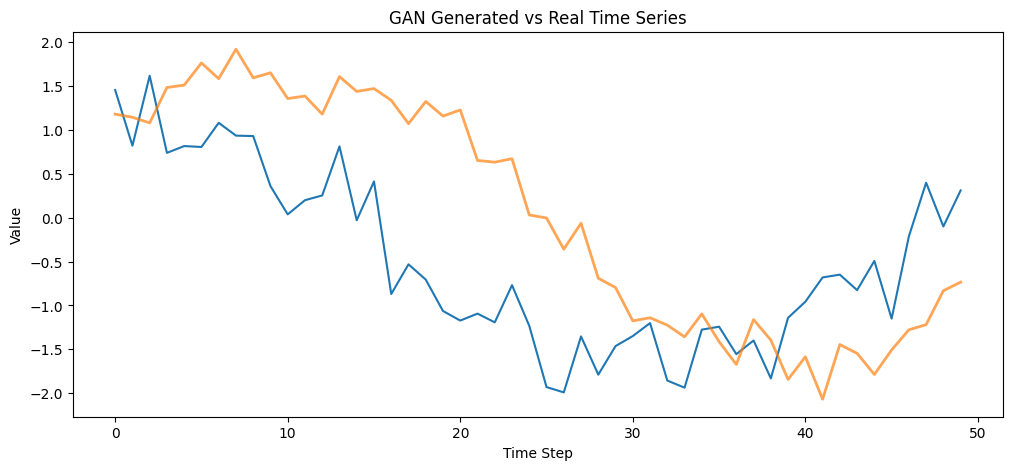

In [5]:
import matplotlib.pyplot as plt

num_windows = 10
window_length = ell

synthetic_series = []
d_pred = []

# Start with random history for the first window
real_series = generate_real_series(num_windows, 2*ell)
history = real_series[:,:ell]  # shape: (ell,)
real_window = real_series[:,ell:2*ell]  # shape: (ell,)

for i in range(num_windows):
    noise = np.random.normal(0, 1, (f,))
    gen_input = np.concatenate([history[i,:], noise])[np.newaxis, :]  # shape (1, ell+f)
    window = generator.predict(gen_input, verbose=0)[0]
    d_pred.append(discriminator.predict(window[np.newaxis, :], verbose=0))
    synthetic_series.append(window)

print("Discriminator output on generated data:", np.array(d_pred).flatten())
print("Mean probability of being real (should be close to 0.5 if fooled):", np.array(d_pred).mean())

plt.figure(figsize=(12, 5))
plt.plot(synthetic_series[0], label="Generated Synthetic Series (Contextual)")
plt.plot(real_window[0,:], label="Real Series", linewidth=2, alpha=0.7)
plt.title("GAN Generated vs Real Time Series")
plt.xlabel("Time Step")
plt.ylabel("Value")

## 4. Generating SPY data

- We next apply GANs to the problem of generating financial times series. 

- Typically, one defines a model for, say, SPY log returns, such as a geometric brownian motion

- This means assuming that daily log returns are independent and identically distributed and all have Gaussian distribution

- Other distributions are also possible to account for skewness and kurtosis

- However, long range dependence of the time series of absolute and squared returns show a phenomenon called volatility clustering

- This means that days of high market activity are typically followed by other days of also high market activity, although perhaps not in the same direction

- GANs offer a way to build a time series generator that mimics the long range dependencies encountered in financial times series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('tensorflow_addons').setLevel(logging.ERROR)

In [2]:
# Libraries
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to force CPU usage
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

import h5py
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Enable mixed precision if your GPU supports it (RTX 20xx/30xx/40xx or newer)
# try:
#     from tensorflow.keras import mixed_precision
#     mixed_precision.set_global_policy('mixed_float16')
#     print("Mixed precision enabled.")
# except Exception as e:
#     print("Mixed precision not enabled:", e)

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("h5py:", h5py.__version__)
print("GPUs available to TensorFlow:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA version:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN version:", tf.sysconfig.get_build_info().get("cudnn_version"))
!nvcc --version

TensorFlow: 2.10.1
NumPy: 1.24.4
h5py: 3.7.0
GPUs available to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
CUDA version: 64_112
cuDNN version: 64_8
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
# Parameters
ell = 100   # Length of each time series sample
f = 20   # Size of the noise vector
T = 10000  # Length of time series
batch_size = 128 # Larger batch size for better GPU utilization
epochs = 1000

# Download SPY data for the last 15 years
spy = yf.download("SPY", period="15y")

# Compute log returns from 'Close' price
spy_close = spy['Close'].dropna()
spy_logret = np.log(spy_close).diff().dropna().values  # log returns

# Standardize log returns to [-1, 1] for GAN training
spy_min = spy_logret.min()
spy_max = spy_logret.max()
spy_scaled = 2 * (spy_logret - spy_min) / (spy_max - spy_min) - 1

def inverse_transform(scaled, data_min, data_max):
    """Inverse of min-max scaling to [-1, 1]."""
    return 0.5 * (scaled + 1) * (data_max - data_min) + data_min

# Create overlapping windows of length 2*ell
def create_windows(series, window_length):
    n_windows = len(series) - window_length + 1
    return np.array([series[i:i+window_length] for i in range(n_windows)])

spy_windows = create_windows(spy_scaled, 2*ell)

print("Shape of SPY windows (log returns):", spy_windows.shape)

def get_real_batch(real_series, batch_size, window_length):
    idx = np.random.randint(0, real_series.shape[0], batch_size)
    batch = real_series[idx, :window_length]  # shape: (batch_size, window_length)
    return batch


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape of SPY windows (log returns): (3574, 200, 1)


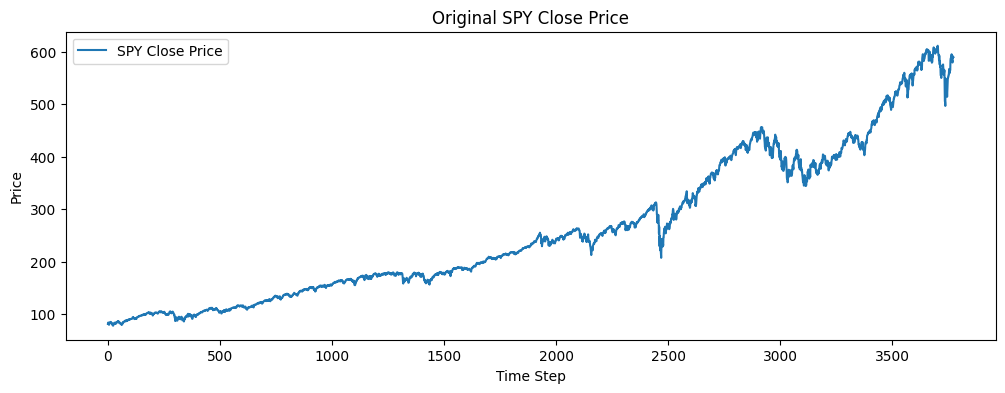

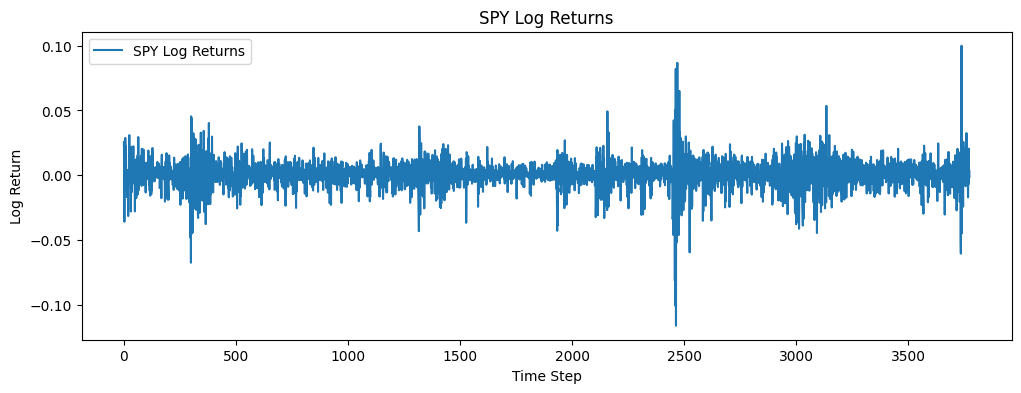

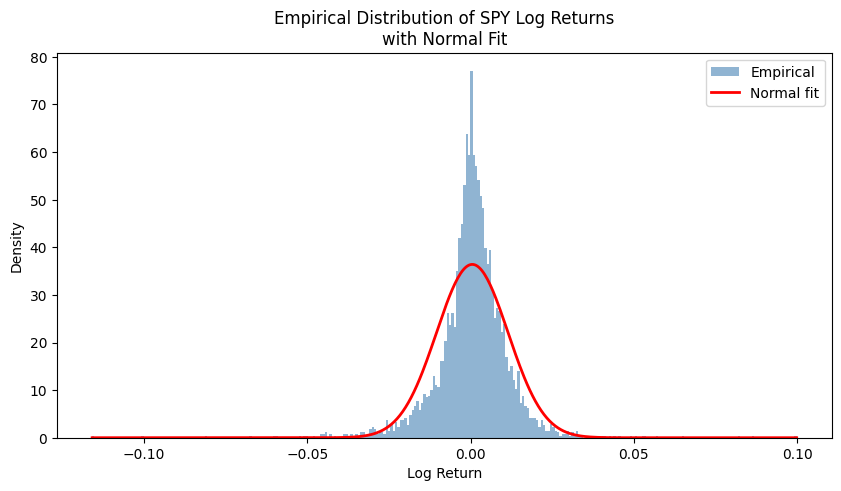

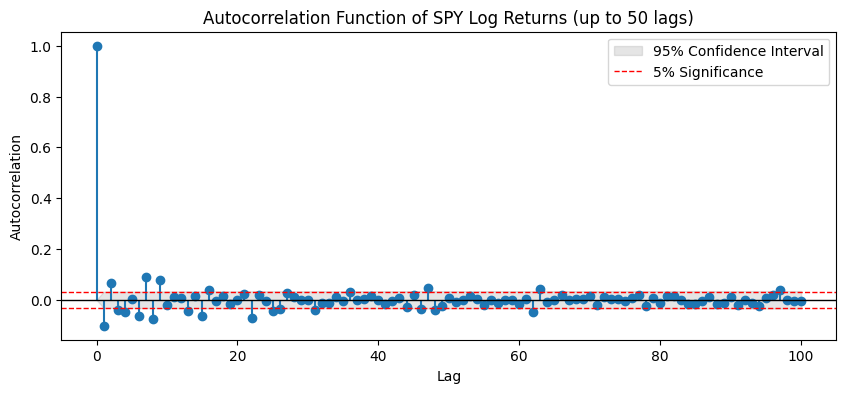

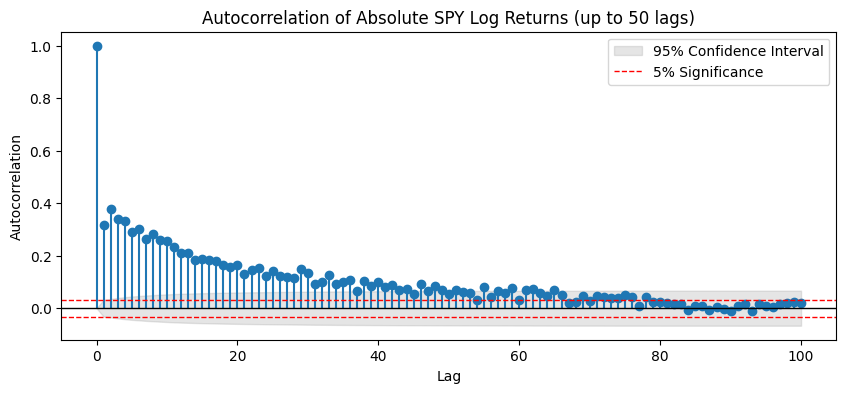

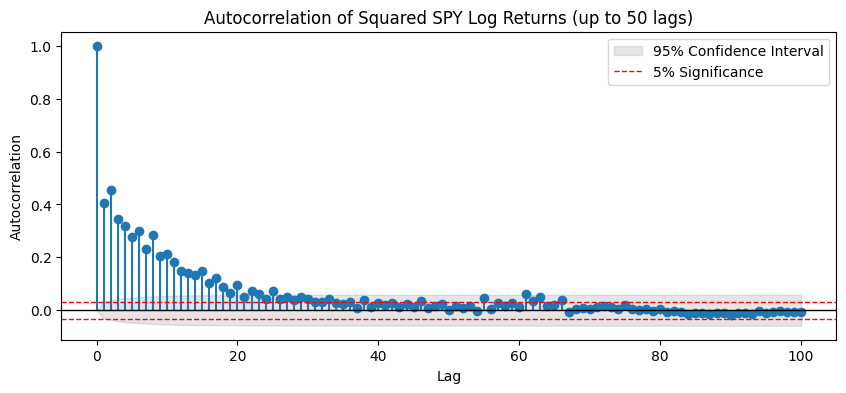

In [4]:
# Empirical properties of SPY log returns

# 1. Plot the original SPY close price
plt.figure(figsize=(12, 4))
plt.plot(spy['Close'].dropna().values, label="SPY Close Price")
plt.title("Original SPY Close Price")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

# 2. Plot the SPY log returns
plt.figure(figsize=(12, 4))
plt.plot(spy_logret, label="SPY Log Returns")
plt.title("SPY Log Returns")
plt.xlabel("Time Step")
plt.ylabel("Log Return")
plt.legend()
plt.show()

# 3. Plot the empirical distribution (histogram) of log returns and compare with normal
plt.figure(figsize=(10, 5))
# Use many more bins for a finer histogram
count, bins, ignored = plt.hist(spy_logret, bins=300, density=True, alpha=0.6, color='steelblue', label='Empirical')

# Normal fit
mu, sigma = np.mean(spy_logret), np.std(spy_logret)
x = np.linspace(np.min(spy_logret), np.max(spy_logret), 500)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal fit')

plt.title("Empirical Distribution of SPY Log Returns\nwith Normal Fit")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# 4. Plot the autocorrelation function of log returns (up to 100 lags, with significance lines)
nlags = 100
alpha = 0.05

acf_vals, confint, qstat, pvalues = acf(spy_logret, nlags=nlags, fft=True, alpha=alpha, qstat=True)
lags = np.arange(len(acf_vals))
lower = confint[:, 0] - acf_vals
upper = confint[:, 1] - acf_vals
sig_level = 1.96 / np.sqrt(len(spy_logret))  # Approximate 5% significance for white noise

plt.figure(figsize=(10, 4))
plt.stem(lags, acf_vals, basefmt=" ")
plt.fill_between(lags, lower, upper, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(sig_level, color='red', linestyle='--', linewidth=1, label='5% Significance')
plt.axhline(-sig_level, color='red', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=1)
plt.title("Autocorrelation Function of SPY Log Returns (up to 50 lags)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# 5. Absolute log returns
acf_abs, confint_abs, *_ = acf(np.abs(spy_logret), nlags=nlags, fft=True, alpha=alpha, qstat=True)
lower_abs = confint_abs[:, 0] - acf_abs
upper_abs = confint_abs[:, 1] - acf_abs

plt.figure(figsize=(10, 4))
plt.stem(lags, acf_abs, basefmt=" ")
plt.fill_between(lags, lower_abs, upper_abs, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(sig_level, color='red', linestyle='--', linewidth=1, label='5% Significance')
plt.axhline(-sig_level, color='red', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=1)
plt.title("Autocorrelation of Absolute SPY Log Returns (up to 50 lags)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# 6. Squared log returns
acf_sq, confint_sq, *_ = acf(spy_logret**2, nlags=nlags, fft=True, alpha=alpha, qstat=True)
lower_sq = confint_sq[:, 0] - acf_sq
upper_sq = confint_sq[:, 1] - acf_sq

plt.figure(figsize=(10, 4))
plt.stem(lags, acf_sq, basefmt=" ")
plt.fill_between(lags, lower_sq, upper_sq, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(sig_level, color='red', linestyle='--', linewidth=1, label='5% Significance')
plt.axhline(-sig_level, color='red', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=1)
plt.title("Autocorrelation of Squared SPY Log Returns (up to 50 lags)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

In [5]:
# === Model Architectures ===

def build_generator(f, ell):
    import tensorflow as tf
    from tensorflow.keras import layers
    import tensorflow_addons as tfa

    num_heads = 8
    key_dim = 16

    inputs = tf.keras.Input(shape=(f + ell,), dtype=tf.float32)
    x = tfa.layers.SpectralNormalization(layers.Dense(ell * 32))(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((ell, 32))(x)
    skip = x  # Skip connection

    # 3 causal residual blocks
    for _ in range(3):
        x_in = x
        x = tfa.layers.SpectralNormalization(
            layers.Conv1D(64, 3, padding='causal'))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        if x_in.shape[-1] != x.shape[-1]:
            x_in = tfa.layers.SpectralNormalization(
                layers.Conv1D(64, 1, padding='same'))(x_in)
        x = layers.Add()([x, x_in])

    # Causal self-attention block
    causal_mask = tf.linalg.band_part(tf.ones((ell, ell), dtype=tf.bool), -1, 0)

    def mask_fn(inputs):
        batch_size = tf.shape(inputs)[0]
        mask = tf.expand_dims(causal_mask, axis=0)         # shape (1, ell, ell)
        mask = tf.expand_dims(mask, axis=1)                # shape (1, 1, ell, ell)
        mask = tf.tile(mask, [batch_size, num_heads, 1, 1])
        return mask

    # Use Lambda to build dynamic batch mask
    attn_mask = layers.Lambda(mask_fn)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        x, x, x, attention_mask=attn_mask)
    
    # Residual attention connection
    if x.shape[-1] != attn.shape[-1]:
        x = tfa.layers.SpectralNormalization(
            layers.Conv1D(attn.shape[-1], 1, padding='same'))(x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Final 3 conv residual blocks
    for _ in range(3):
        x_in = x
        x = tfa.layers.SpectralNormalization(
            layers.Conv1D(64, 3, padding='causal'))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        if x_in.shape[-1] != x.shape[-1]:
            x_in = tfa.layers.SpectralNormalization(
                layers.Conv1D(64, 1, padding='same'))(x_in)
        x = layers.Add()([x, x_in])

    x = tfa.layers.SpectralNormalization(
        layers.Conv1D(1, 1, padding='same'))(x)
    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model


def build_discriminator(ell):
    inputs = keras.Input(shape=(ell,))
    x = layers.Reshape((ell, 1))(inputs)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(64, 3, padding='same'))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(128, 3, padding='same'))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = tfa.layers.SpectralNormalization(layers.Dense(1))(x)  # no sigmoid
    return keras.Model(inputs, outputs)



# === Loss Functions ===

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def gradient_penalty(discriminator, real, fake):
    real = tf.convert_to_tensor(real)
    fake = tf.convert_to_tensor(fake)
    
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform(shape=[batch_size, 1], minval=0., maxval=1.)
    alpha = tf.broadcast_to(alpha, tf.shape(real))

    interpolated = alpha * real + (1 - alpha) * fake
    interpolated = tf.cast(interpolated, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)

    grads = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    return tf.reduce_mean((norm - 1.0) ** 2)


def moment_loss(real, fake):
    mean_loss = tf.reduce_mean((tf.reduce_mean(real, axis=1) - tf.reduce_mean(fake, axis=1))**2)
    var_loss = tf.reduce_mean((tf.math.reduce_variance(real, axis=1) - tf.math.reduce_variance(fake, axis=1))**2)
    return mean_loss + var_loss

def autocorr_loss(real, fake, lag=1):
    def autocorr(x, lag):
        x_centered = x - tf.reduce_mean(x, axis=1, keepdims=True)
        return tf.reduce_mean(x_centered[:, :-lag] * x_centered[:, lag:], axis=1)
    return tf.reduce_mean((autocorr(real, lag) - autocorr(fake, lag))**2)

# === Training Step ===

# --- Core Training Step ---
@tf.function
def train_step(real_series, generator, discriminator, g_optimizer, d_optimizer, lambda_gp, lambda_moment, lambda_acf):
    batch_size = tf.shape(real_series)[0]
    f = generator.input_shape[1] - generator.output_shape[1]
    ell = generator.output_shape[1]

    # Sample history + noise
    history = real_series[:, :ell]
    noise = tf.random.normal((batch_size, f))
    history = tf.squeeze(history, axis=-1)  # shape: [batch_size, ell]
    gen_input = tf.concat([history, noise], axis=1)

    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_series = generator(gen_input, training=True)  # shape: [batch_size, ell]

        # Ensure both are [batch_size, ell, 1]
        real_target = tf.expand_dims(real_series[:, ell:], axis=-1)  # [batch_size, ell, 1]
        fake_series = tf.expand_dims(fake_series, axis=-1) if len(fake_series.shape) == 2 else fake_series

        # Fix accidental 4D shapes
        if len(real_target.shape) == 4:
            real_target = tf.squeeze(real_target, axis=-1)
        if len(fake_series.shape) == 4:
            fake_series = tf.squeeze(fake_series, axis=-1)

        real_out = discriminator(real_target, training=True)
        fake_out = discriminator(fake_series, training=True)

        # Discriminator loss
        d_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out)

        # Gradient penalty
        alpha = tf.random.uniform((batch_size, 1, 1), 0.0, 1.0)
        interpolated = alpha * real_target + (1 - alpha) * fake_series
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = discriminator(interpolated)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        gp = tf.reduce_mean((tf.norm(grads, axis=list(range(1, len(grads.shape)))) - 1.0) ** 2)
        d_loss += lambda_gp * gp

        # Generator loss (Wasserstein)
        g_loss = -tf.reduce_mean(fake_out)

        # --- Moment matching (mean) ---
        real_mean = tf.reduce_mean(real_target)
        fake_mean = tf.reduce_mean(fake_series)
        moment_loss = tf.abs(real_mean - fake_mean)

        # --- ACF loss on squared returns ---
        def batch_acf(x):
            x = tf.reshape(x, [batch_size, ell])
            x = x - tf.reduce_mean(x, axis=1, keepdims=True)
            fft = tf.signal.rfft(x)
            acf = tf.signal.irfft(fft * tf.math.conj(fft))
            acf = acf / tf.cast(ell, tf.float32)
            return acf[:, :20]

        real_acf2 = batch_acf(tf.square(real_target))
        fake_acf2 = batch_acf(tf.square(fake_series))
        acf_loss = tf.reduce_mean(tf.square(real_acf2 - fake_acf2))

        # Total generator loss
        g_loss += lambda_moment * moment_loss + lambda_acf * acf_loss

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    # Approximate D and G accuracy (optional)
    d_acc = tf.reduce_mean(tf.cast(real_out > fake_out, tf.float32))
    g_acc = tf.reduce_mean(tf.cast(fake_out > real_out, tf.float32))

    return d_loss, g_loss, d_acc, g_acc


# --- Training Loop ---
def wgan_gp_train_loop_with_logging(
    generator,
    discriminator,
    g_optimizer,
    d_optimizer,
    get_real_batch,
    spy_windows,
    f,
    ell,
    spy_min,
    spy_max,
    epochs=15000,
    batch_size=64,
    check_every=100,
    plot_every=1000,
    patience=20,
    lambda_gp=10.0,
    lambda_moment=1.0,
    lambda_acf=2.0,
    checkpoint_path="best_generator_weights.h5"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import acf

    best_g_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        real_batch = get_real_batch(spy_windows, batch_size, 2 * ell).astype(np.float32)
        d_loss, g_loss, d_acc, g_acc = train_step(
            real_batch, generator, discriminator, g_optimizer, d_optimizer,
            lambda_gp, lambda_moment, lambda_acf
        )

        if epoch % check_every == 0:
            print(f"Epoch {epoch}: D_loss={d_loss.numpy():.4f}, G_loss={g_loss.numpy():.4f}, D_acc={d_acc.numpy():.2f}, G_acc={g_acc.numpy():.2f}")

            if g_loss < best_g_loss - 1e-4:
                best_g_loss = g_loss
                patience_counter = 0
                generator.save_weights(checkpoint_path)
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                generator.load_weights(checkpoint_path)
                break

        if epoch % plot_every == 0:
            # Generate samples
            history = get_real_batch(spy_windows, 100, ell).astype(np.float32)
            noise = np.random.normal(0, 1, (100, f)).astype(np.float32)
            history_flat = history[:, :, 0]  # squeeze to shape [100, ell]
            gen_input = np.concatenate([history_flat, noise], axis=1).astype(np.float32)
            fake_series = generator.predict(gen_input, verbose=0).flatten()
            real_series = spy_windows[:len(fake_series)].flatten().astype(np.float32)

            # Inverse transform
            fake_orig = fake_series * (spy_max - spy_min) + spy_min
            real_orig = real_series * (spy_max - spy_min) + spy_min

            # Plot histogram
            plt.figure(figsize=(8, 4))
            plt.hist(fake_orig, bins=50, alpha=0.6, density=True, label="Generated")
            plt.hist(real_orig, bins=50, alpha=0.4, density=True, label="Real")
            plt.title(f"Empirical Distribution at Epoch {epoch}")
            plt.legend()
            plt.show()

            # Plot ACF with CI
            def acf_ci(data):
                val, conf = acf(data, nlags=49, alpha=0.05)
                return val, conf[:, 0] - val, conf[:, 1] - val

            for label, series in [("Log Returns", fake_orig), ("Abs Returns", np.abs(fake_orig)), ("Squared Returns", fake_orig ** 2)]:
                fake_acf, fake_lo, fake_hi = acf_ci(series)
                real_acf, real_lo, real_hi = acf_ci(real_orig if "Log" in label else np.abs(real_orig) if "Abs" in label else real_orig ** 2)
                plt.figure(figsize=(8, 4))
                plt.stem(range(50), real_acf, markerfmt='ro', label="Real", basefmt=" ")
                plt.stem(range(50), fake_acf, markerfmt='bo', label="Fake", basefmt=" ")
                plt.fill_between(range(50), real_lo, real_hi, color='r', alpha=0.15, label='95% CI Real')
                plt.fill_between(range(50), fake_lo, fake_hi, color='b', alpha=0.1, label='95% CI Fake')
                plt.title(f"ACF - {label}")
                plt.legend()
                plt.show()


Epoch 0: D_loss=8.1864, G_loss=4.2061, D_acc=0.39, G_acc=0.61


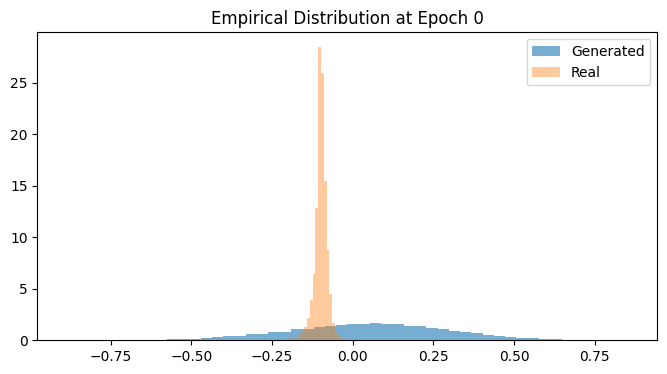

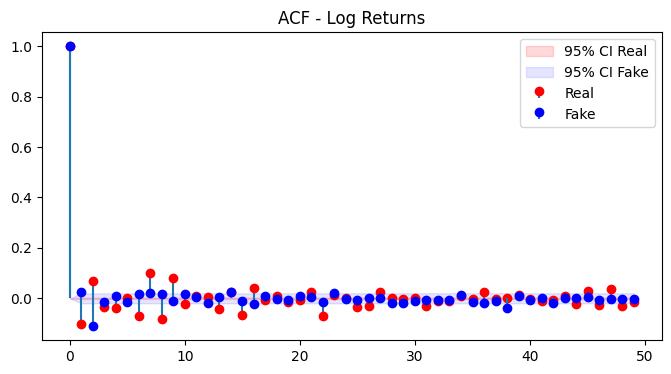

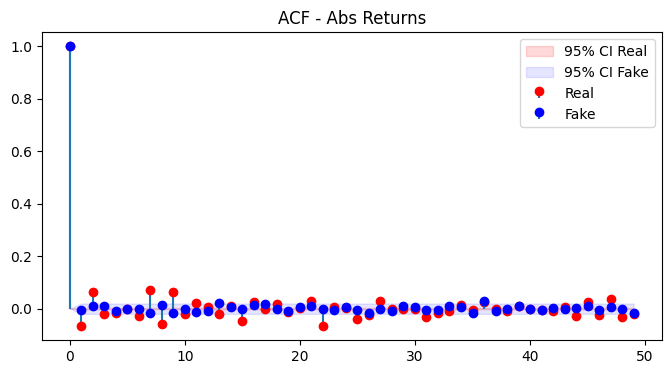

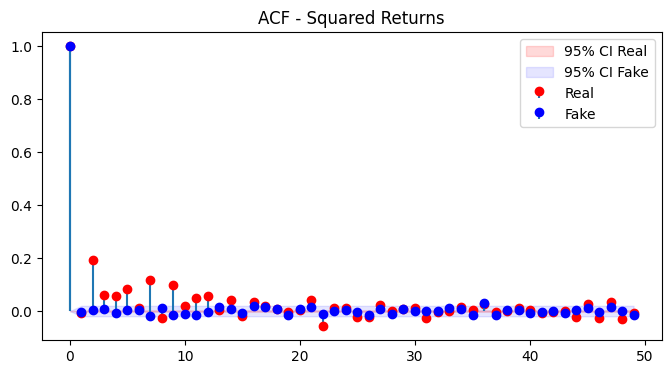

Epoch 100: D_loss=0.3041, G_loss=-0.9514, D_acc=0.73, G_acc=0.27
Epoch 200: D_loss=0.0137, G_loss=-1.1383, D_acc=0.69, G_acc=0.31
Epoch 300: D_loss=0.2118, G_loss=-1.9225, D_acc=0.03, G_acc=0.97
Epoch 400: D_loss=0.2089, G_loss=-1.9881, D_acc=0.11, G_acc=0.89
Epoch 500: D_loss=0.1524, G_loss=-1.9249, D_acc=0.17, G_acc=0.83
Epoch 600: D_loss=0.1451, G_loss=-1.8763, D_acc=0.17, G_acc=0.83
Epoch 700: D_loss=0.0994, G_loss=-1.7507, D_acc=0.33, G_acc=0.67
Epoch 800: D_loss=0.0659, G_loss=-1.5667, D_acc=0.56, G_acc=0.44
Epoch 900: D_loss=0.0341, G_loss=-1.4324, D_acc=0.62, G_acc=0.38
Epoch 1000: D_loss=0.0717, G_loss=-1.4724, D_acc=0.33, G_acc=0.67


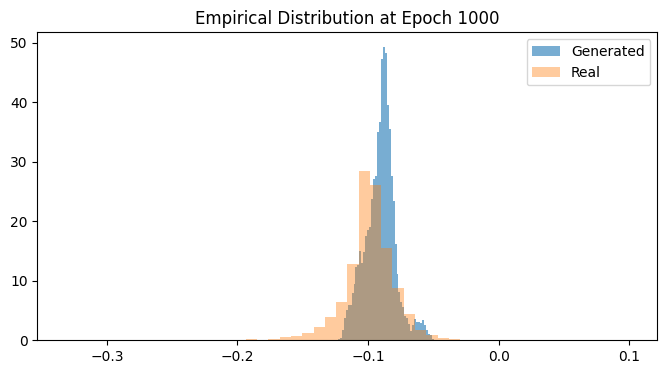

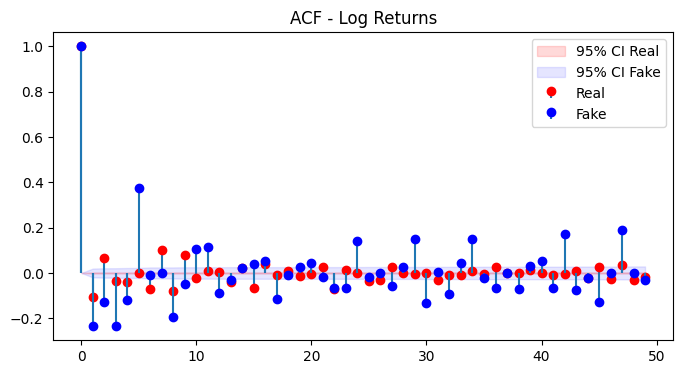

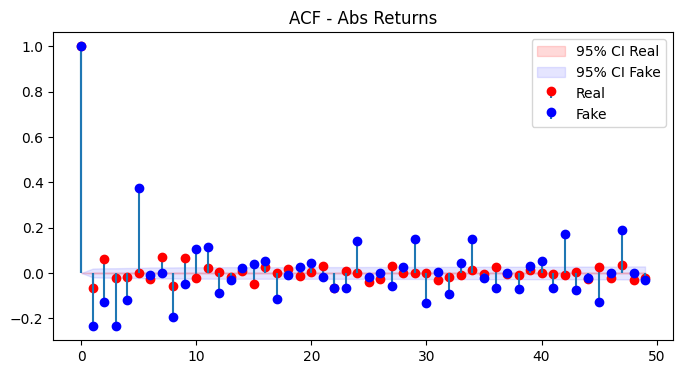

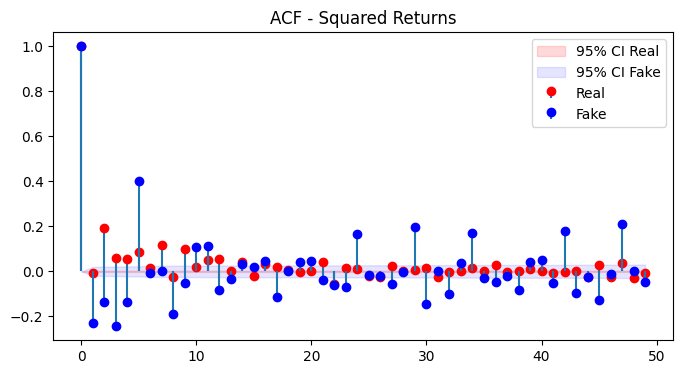

Epoch 1100: D_loss=0.0614, G_loss=-1.3119, D_acc=0.58, G_acc=0.42
Epoch 1200: D_loss=0.0897, G_loss=-1.3376, D_acc=0.25, G_acc=0.75
Epoch 1300: D_loss=0.0875, G_loss=-1.3388, D_acc=0.28, G_acc=0.72
Epoch 1400: D_loss=0.0527, G_loss=-1.2253, D_acc=0.39, G_acc=0.61
Epoch 1500: D_loss=0.0589, G_loss=-1.3128, D_acc=0.33, G_acc=0.67
Epoch 1600: D_loss=0.0341, G_loss=-1.2980, D_acc=0.41, G_acc=0.59
Epoch 1700: D_loss=0.0476, G_loss=-1.1630, D_acc=0.34, G_acc=0.66
Epoch 1800: D_loss=0.0488, G_loss=-1.2106, D_acc=0.45, G_acc=0.55
Epoch 1900: D_loss=0.0143, G_loss=-1.0850, D_acc=0.75, G_acc=0.25
Epoch 2000: D_loss=0.0372, G_loss=-1.4868, D_acc=0.52, G_acc=0.48


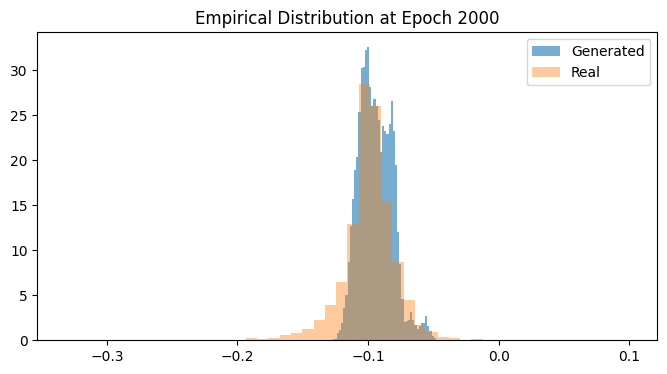

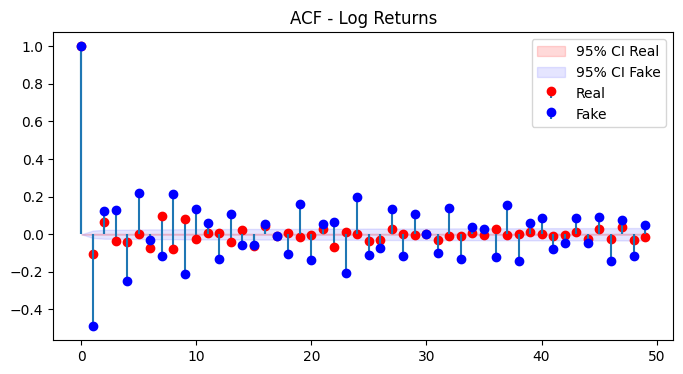

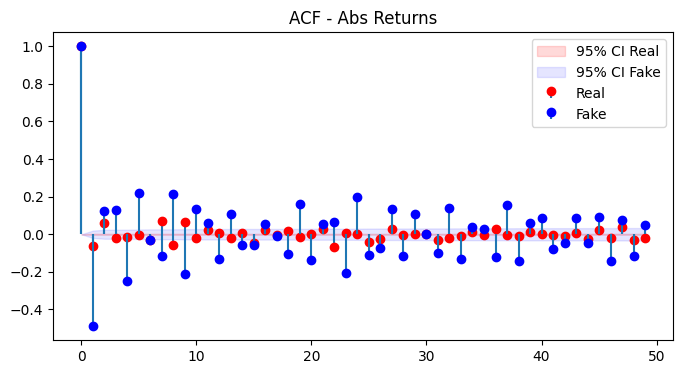

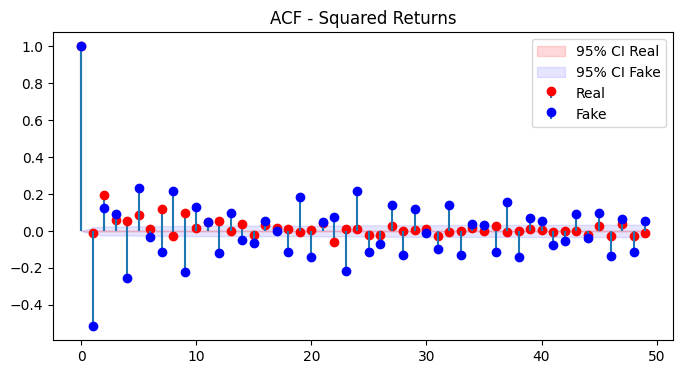

Epoch 2100: D_loss=0.0180, G_loss=-1.7308, D_acc=0.47, G_acc=0.53
Epoch 2200: D_loss=0.0049, G_loss=-1.7396, D_acc=0.56, G_acc=0.44
Epoch 2300: D_loss=0.0160, G_loss=-1.5669, D_acc=0.41, G_acc=0.59
Epoch 2400: D_loss=0.0930, G_loss=-1.5440, D_acc=0.20, G_acc=0.80
Early stopping triggered


In [6]:
generator = build_generator(f, ell)
discriminator = build_discriminator(ell)


# Dummy inputs
dummy_input_g = tf.random.normal((1, f + ell))
dummy_input_d = tf.random.normal((1, ell))

# Force variable creation
_ = generator(dummy_input_g)
_ = discriminator(dummy_input_d)


g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

# Initialize both optimizers by applying them to dummy variables
_ = g_optimizer.iterations  # Force creation of internal tf.Variables
_ = d_optimizer.iterations

wgan_gp_train_loop_with_logging(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    get_real_batch=get_real_batch,
    spy_windows=spy_windows,
    f=f,
    ell=ell,
    spy_min=spy_min,
    spy_max=spy_max,
    epochs=15000,
    batch_size=64,
    check_every=100,
    plot_every=1000,
    patience=20,
    lambda_gp=10.0,
    lambda_moment=1.0,
    lambda_acf=0.5,
    checkpoint_path="best_generator_weights.h5"
)





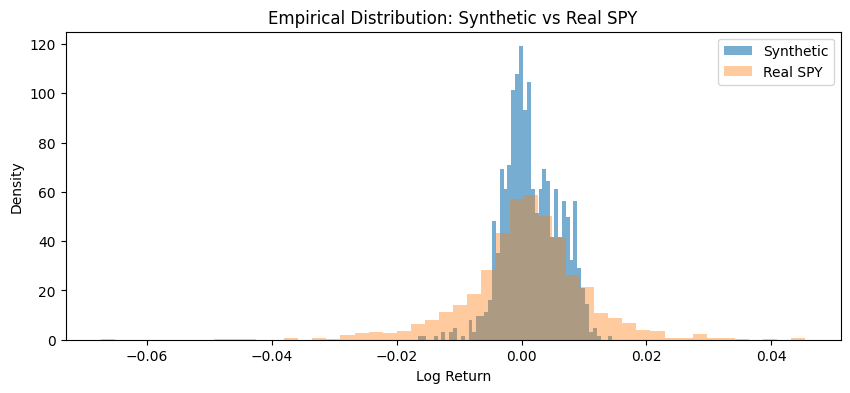

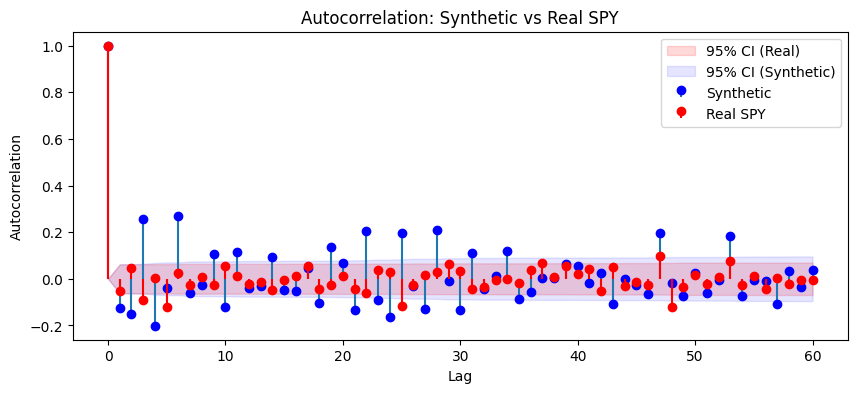

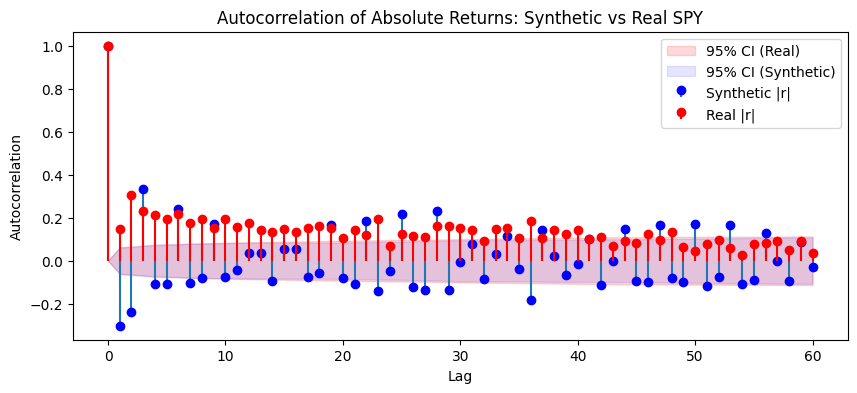

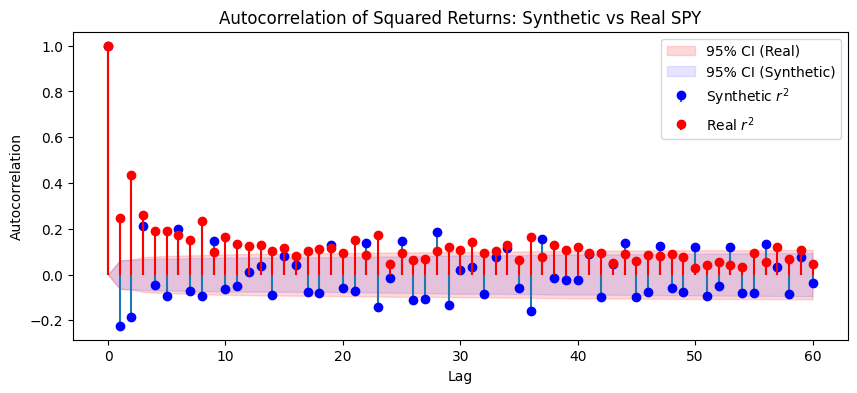

In [7]:
# Generate 1000 days of synthetic data using the trained generator
n_days = 1000
synthetic_full = []

# Start with a random real window as history
init_idx = np.random.randint(0, spy_windows.shape[0])
history = spy_windows[init_idx, :ell, 0].copy()

for _ in range(n_days // ell):
    noise = np.random.normal(0, 1, (f,))
    gen_input = np.concatenate([history, noise])[np.newaxis, :]
    synthetic_window = generator.predict(gen_input, verbose=0)[0]
    synthetic_full.extend(synthetic_window)
    # For next window, use the last ell values as new history
    history = synthetic_window

synthetic_full = np.array(synthetic_full[:n_days])

# Inverse transform to original scale

synthetic_full_orig = inverse_transform(synthetic_full, spy_min, spy_max)

# Plot empirical distribution
plt.figure(figsize=(10, 4))
plt.hist(synthetic_full_orig, bins=50, density=True, alpha=0.6, label="Synthetic")
plt.hist(inverse_transform(spy_scaled[:n_days], spy_min, spy_max), bins=50, density=True, alpha=0.4, label="Real SPY")
plt.title("Empirical Distribution: Synthetic vs Real SPY")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot autocorrelation function

lags = 60

# --- Helper for confidence intervals ---
def acf_with_ci(series, lags, alpha=0.05):
    acf_vals, confint = acf(series, nlags=lags, alpha=alpha, fft=True)
    lower = confint[:, 0] - acf_vals
    upper = confint[:, 1] - acf_vals
    return acf_vals, lower, upper

# --- Standard returns ---
acf_synth, lower_synth, upper_synth = acf_with_ci(synthetic_full_orig, lags)
acf_real, lower_real, upper_real = acf_with_ci(inverse_transform(spy_scaled[:n_days], spy_min, spy_max), lags)

plt.figure(figsize=(10, 4))
plt.stem(range(lags+1), acf_synth, basefmt=" ", markerfmt="bo", label="Synthetic")
plt.stem(range(lags+1), acf_real, basefmt=" ", markerfmt="ro", label="Real SPY", linefmt="r-")
plt.fill_between(range(lags+1), lower_real, upper_real, color='red', alpha=0.15, label='95% CI (Real)')
plt.fill_between(range(lags+1), lower_synth, upper_synth, color='blue', alpha=0.10, label='95% CI (Synthetic)')
plt.title("Autocorrelation: Synthetic vs Real SPY")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# --- Absolute returns ---
acf_synth_abs, lower_synth_abs, upper_synth_abs = acf_with_ci(np.abs(synthetic_full_orig), lags)
acf_real_abs, lower_real_abs, upper_real_abs = acf_with_ci(np.abs(inverse_transform(spy_scaled[:n_days], spy_min, spy_max)), lags)

plt.figure(figsize=(10, 4))
plt.stem(range(lags+1), acf_synth_abs, basefmt=" ", markerfmt="bo", label="Synthetic |r|")
plt.stem(range(lags+1), acf_real_abs, basefmt=" ", markerfmt="ro", label="Real |r|", linefmt="r-")
plt.fill_between(range(lags+1), lower_real_abs, upper_real_abs, color='red', alpha=0.15, label='95% CI (Real)')
plt.fill_between(range(lags+1), lower_synth_abs, upper_synth_abs, color='blue', alpha=0.10, label='95% CI (Synthetic)')
plt.title("Autocorrelation of Absolute Returns: Synthetic vs Real SPY")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# --- Squared returns ---
acf_synth_sq, lower_synth_sq, upper_synth_sq = acf_with_ci(synthetic_full_orig**2, lags)
acf_real_sq, lower_real_sq, upper_real_sq = acf_with_ci(inverse_transform(spy_scaled[:n_days], spy_min, spy_max)**2, lags)

plt.figure(figsize=(10, 4))
plt.stem(range(lags+1), acf_synth_sq, basefmt=" ", markerfmt="bo", label="Synthetic $r^2$")
plt.stem(range(lags+1), acf_real_sq, basefmt=" ", markerfmt="ro", label="Real $r^2$", linefmt="r-")
plt.fill_between(range(lags+1), lower_real_sq, upper_real_sq, color='red', alpha=0.15, label='95% CI (Real)')
plt.fill_between(range(lags+1), lower_synth_sq, upper_synth_sq, color='blue', alpha=0.10, label='95% CI (Synthetic)')
plt.title("Autocorrelation of Squared Returns: Synthetic vs Real SPY")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()